# Heat equation

## imports

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from IPython.display import HTML
from scipy import special
import math

import seaborn as sns

## initialization

In [18]:
X_max = 100
Y_max = 120
X_min = Y_min = 0

NUMBER_X = 1000
NUMBER_Y = 1000

In [19]:
X_RANGE = np.linspace(X_min, X_max, NUMBER_X)
Y_RANGE = np.linspace(Y_min, Y_max, NUMBER_Y)

X_STEP = X_RANGE[1] - X_RANGE[0]
Y_STEP = Y_RANGE[1] - Y_RANGE[0]

In [20]:
X, Y = np.meshgrid(X_RANGE, Y_RANGE, indexing='ij')

T = np.zeros_like(X)
lambdas = np.ones_like(X)
source_c = np.zeros_like(X) 
source_p = np.zeros_like(X)

In [21]:
current_lambdas = lambdas[1, :]
upper_lambdas = lambdas[1+1, :]
lower_lambdas = lambdas[1-1, :]

In [22]:
def calculate_coefficients(alpha, beta, current_u, upper_u, lower_u, s, current_lambdas, upper_lambdas, lower_lambdas, kind):
    """makes Thomas algorithm for longituginal and transversal kinds"""
    if kind == 'longituginal':
        size_x = X_STEP
        size_y = Y_STEP
        
    elif kind == 'transversal':
        size_x = Y_STEP
        size_y = X_STEP

    a  = lower_lambdas / (lower_lambdas + current_lambdas) / size_x ** 2
    b  = upper_lambdas / (upper_lambdas + current_lambdas) / size_x ** 2
    c = (
        ((np.roll(current_lambdas, -1) + np.roll(current_lambdas, 1)) * current_lambdas + 
        2 * np.roll(current_lambdas, -1) * np.roll(current_lambdas, 1)) /
        (np.roll(current_lambdas, -1) + current_lambdas) / 
        (np.roll(current_lambdas, 1) + current_lambdas) /
        size_y ** 2 +
        ((upper_lambdas + lower_lambdas) * current_lambdas + 
        2 * upper_lambdas * lower_lambdas) /
        (upper_lambdas + current_lambdas) / 
        (lower_lambdas + current_lambdas) /
        size_x ** 2
        )
    d = (
        np.roll(current_lambdas, -1) / (np.roll(current_lambdas, -1) + current_lambdas)
        * np.roll(current_u, -1) / size_y ** 2 + 
        np.roll(current_lambdas, 1) / (np.roll(current_lambdas, 1) + current_lambdas)
        * np.roll(current_u, 1) / size_y ** 2 -
        s / (2 * current_lambdas)
        )

    for i in range(1, len(current_u)-1):
        alpha[i+1] = b[i] / (c[i] - alpha[i] * a[i])
        beta[i+1] = (a[i] * beta[i] + d[i]) / (c[i] - alpha[i] * a[i])
        
    return alpha, beta
    
def thomas_algorithm_trans(U, S, lambdas):
    
    for k in range(1, len(U[1,:]) - 1):
        
        current_u = U[:, k]
        upper_u = U[:, k+1]
        lower_u = U[:, k-1]
        
        s = S[:, k]
        
        current_lambdas = lambdas[:, k]
        upper_lambdas = lambdas[:, k+1]
        lower_lambdas = lambdas[:, k-1]
        
        alpha = np.zeros_like(U[1, :])
        beta = np.zeros_like(U[1, :])

        alpha[1] = 0
        beta[1] = q_left
        
        kind = 'transversal'
        alpha, beta = calculate_coefficients(alpha, beta, current_u, upper_u, lower_u, s, current_lambdas, upper_lambdas, lower_lambdas, kind)

        for m in reversed(range(0, len(U[:,1]) - 1)):
            U[m, k+1] = alpha[m+1] * U[m+1, k+1] + beta[m+1]
            
    return U

def thomas_algorithm_long(U, S, lambdas):
    
    for m in range(1, len(U[:,1]) - 1):
        
        current_u = U[m, :]
        upper_u = U[m+1, :]
        lower_u = U[m-1, :]
        
        s = S[m, :]
        
        current_lambdas = lambdas[m, :]
        upper_lambdas = lambdas[m+1, :]
        lower_lambdas = lambdas[m-1, :]
             
        alpha = np.zeros_like(U[1, :])
        beta = np.zeros_like(U[1, :])

        alpha[1] = 0
        beta[1] = current_u[0]

        kind = 'longituginal'
        
        alpha, beta = calculate_coefficients(alpha, beta, current_u, upper_u, lower_u, s, current_lambdas, upper_lambdas, lower_lambdas, kind)

        for k in reversed(range(0, len(U[1,:]) - 1)):
            U[m+1, k] = alpha[k+1] * U[m+1, k+1] + beta[k+1]
            
    return U
    
def heatmap2d(arr: np.ndarray):
    plt.imshow(arr, cmap='hot')
    plt.colorbar()
    plt.ylim(0,1000)
    plt.xlim(0,1000)

## boundary conditions

<img src="task3.png" height="100px" width="400px" >

### outlet conditions

In [23]:
T[:, 0] = 0         # lower bound
q_upper = 1         # upper bound
q_left = 0          # left bound
T[-1, :] = 100      # right bound

In [24]:
# lambda_edge = 10 ** 20
# T_edge = 300

### 1

In [25]:
# size_x = int(10 / X_STEP)
# size_y = int(10 / Y_STEP)

# lambdas[0 : size_x, 0 : size_y] = lambda_edge
# T[0 : size_x, 0] = T_edge
# T[0, 0 : size_y] = T_edge

## main procedure

In [26]:
check = True
count = 1

In [27]:
while check:
    T_prev = T.copy()
    
    T = thomas_algorithm_trans(T, source_c, lambdas)
    T = thomas_algorithm_long(T, source_c, lambdas)
    
    T_difference = abs(T_prev - T)
    
    if np.amax(T_difference) < 0.1:
        check = False
        
    count = count + 1

## vizualization

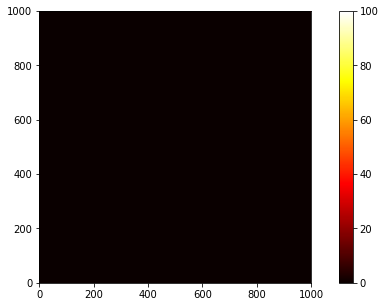

In [28]:
fig, ax = plt.subplots(figsize=(10,5))

heatmap2d(T)